In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds
import itertools

from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import glob
import shutil

In [4]:
BATCH_SIZE = 32
IMG_SHAPE = 224
class_names = ['Fire !!', 'No Fire']

In [5]:
train_path = 'MySecondDataset/train'
valid_path = 'MySecondDataset/validation'
test_path = 'MySecondDataset/test'

In [6]:
image_gen_train = ImageDataGenerator(      
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(directory=train_path, 
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     shuffle=True,
                                                     classes=['Fire', 'NoFire'],
                                                     batch_size=BATCH_SIZE, 
                                                     class_mode='binary')

Found 500 images belonging to 2 classes.


In [7]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=valid_path,
                                                 classes=['Fire', 'NoFire'],
                                                 target_size=(IMG_SHAPE,IMG_SHAPE),
                                                 class_mode='binary')

Found 200 images belonging to 2 classes.


In [8]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_SHAPE, IMG_SHAPE,3))

In [9]:
feature_extractor.trainable = False

In [10]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        plt.xlabel("Actual : " + class_names[int(test_labels[i])])
        if titles is not None:
            #sp.set_title(titles[i], fontsize=16)
            sp.set_title(class_names[int(titles[i])])
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 5
history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)

Train for 16 steps, validate for 7 steps
Epoch 1/5
16/16 [==============================] - 71s 4s/step - loss: 0.5852 - accuracy: 0.7120 - val_loss: 0.4683 - val_accuracy: 0.8950
Epoch 2/5
16/16 [==============================] - 59s 4s/step - loss: 0.3947 - accuracy: 0.9420 - val_loss: 0.4025 - val_accuracy: 0.9250
Epoch 3/5
16/16 [==============================] - 64s 4s/step - loss: 0.3661 - accuracy: 0.9620 - val_loss: 0.3869 - val_accuracy: 0.9450
Epoch 4/5
16/16 [==============================] - 64s 4s/step - loss: 0.3550 - accuracy: 0.9640 - val_loss: 0.3791 - val_accuracy: 0.9550
Epoch 5/5
16/16 [==============================] - 65s 4s/step - loss: 0.3482 - accuracy: 0.9740 - val_loss: 0.3722 - val_accuracy: 0.9550


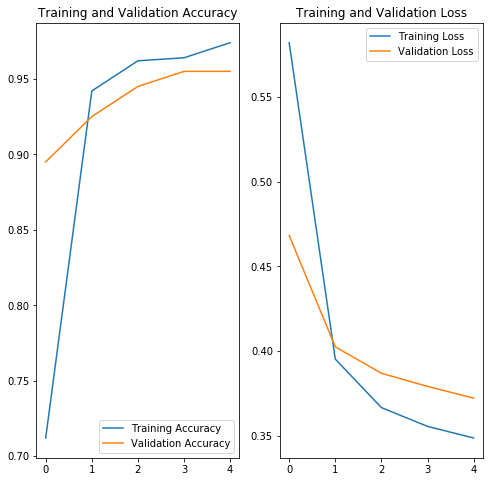

In [16]:
epochs = 5
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
img_gen = ImageDataGenerator()
test_batches = img_gen.flow_from_directory(test_path, target_size=(IMG_SHAPE,IMG_SHAPE), 
                                           classes=['Fire', 'NoFire'], 
                                           batch_size=10,
                                           shuffle=True,
                                           class_mode='binary')

Found 10 images belonging to 2 classes.


[0.9261718  0.07382827]
0
[0.04370929 0.9562907 ]
1
[0.19281112 0.80718887]
1
[0.55348307 0.4465169 ]
0
[0.15457122 0.84542876]
1
[0.71672094 0.283279  ]
0
[0.8733421  0.12665792]
0
[0.39491653 0.6050834 ]
1
[0.9819931  0.01800697]
0
[0.6609979  0.33900207]
0


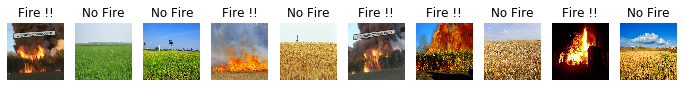

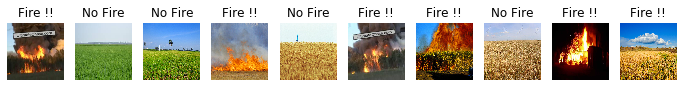

In [18]:
test_imgs, test_labels = next(test_batches)
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

predictions_arr = []
for i in range(0,10):
    predictions_arr.append(np.argmax(predictions[i]))
    print(predictions[i])
    print(predictions_arr[i])
    
plots(test_imgs, titles=test_labels)
plots(test_imgs, titles=predictions_arr)

Confusion matrix, without normalization
[[5 0]
 [1 4]]


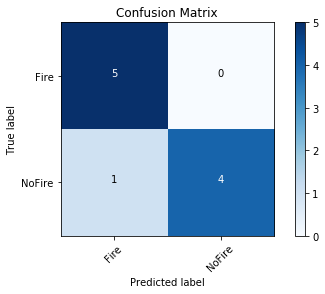

In [19]:
cm = confusion_matrix(test_labels, predictions_arr)
cm_plot_labels=['Fire','NoFire']
plot_confusion_matrix(cm,cm_plot_labels,title="Confusion Matrix")

In [20]:
export_path_keras = "./flamma_facto_model.h5"
print(export_path_keras)

model.save(export_path_keras)

./flamma_facto_model.h5
